In [55]:
import os
import tarfile
from six.moves import urllib
%matplotlib inline

In [56]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

## Download Data

In [57]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [58]:
import pandas as pd

In [59]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [60]:
fetch_housing_data()
housing = load_housing_data()

## Investigate Data Structure

In [61]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [62]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [63]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [64]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [65]:
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ff62470>,
      dtype=object)

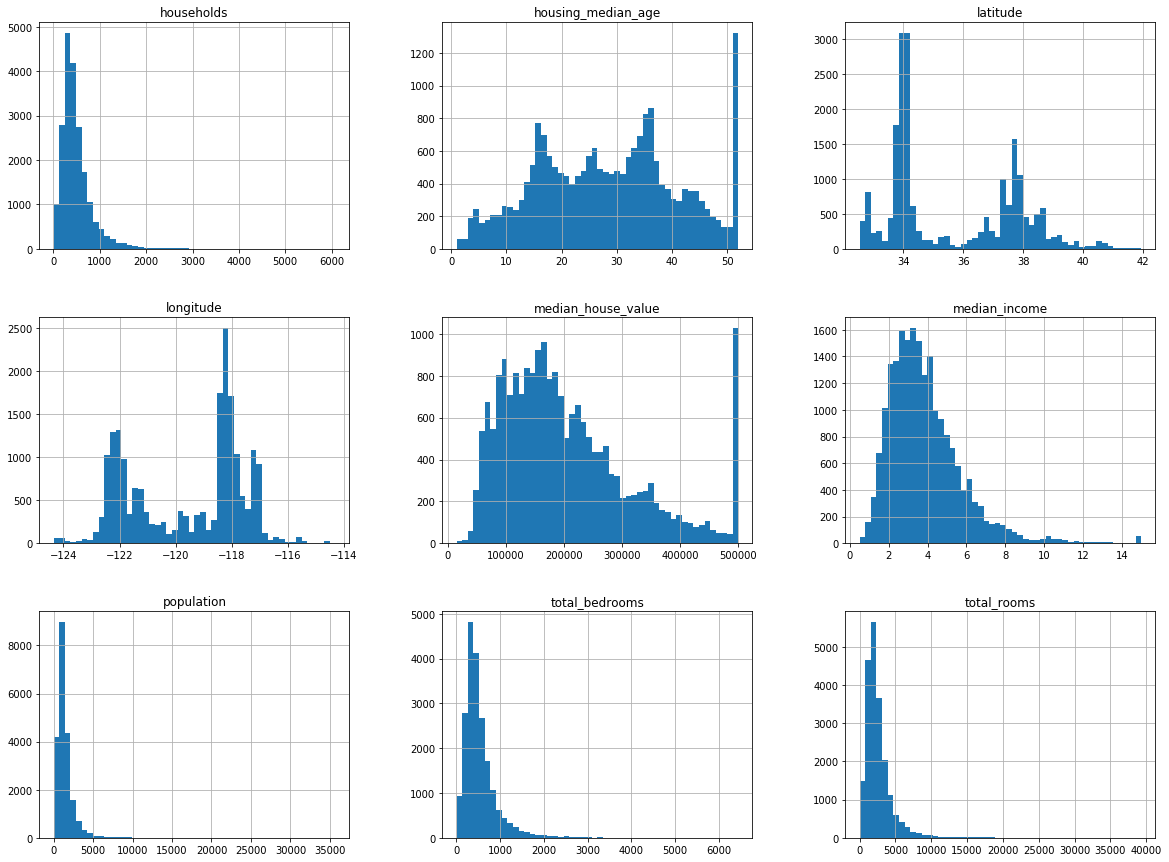

In [66]:
housing.hist(bins=50, figsize=(20,15))

Notice capping, tail heavy and scales

## Create Test Set

In [67]:
import numpy as np

In [68]:
def split_train_test(data, test_ratio):
    shuffled_indicies = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indicies = shuffled_indicies[:test_set_size]
    train_indicies = shuffled_indicies[test_set_size:]
    return data.iloc[train_indicies], data.iloc[test_indicies]

In [69]:
train_set, test_set = split_train_test(housing, 0.2)

In [70]:
print(len(train_set), 'train +', len(test_set), 'test')

16512 train + 4128 test


### Alternative train/test split using hash

In [71]:
import hashlib

In [72]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio,
                                                       hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [73]:
housing_with_id = housing.reset_index() # adds index column, no identifiers before
train_set, test_set = split_train_test_by_id(housing_with_id,0.2, 'index')

In [74]:
print(len(train_set), 'train +', len(test_set), 'test')

16362 train + 4278 test


### Stratified train/test split

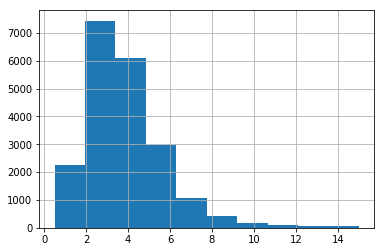

In [75]:
housing['median_income'].hist()

In [76]:
# Divide by 1.5 to limit the number of income categories
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
# Label anything above 5 as 5
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

In [77]:
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

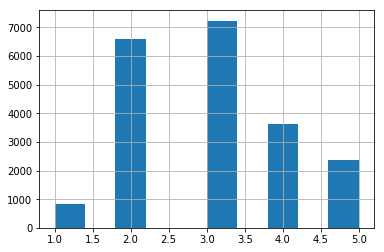

In [78]:
housing['income_cat'].hist()

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit

In [80]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index,:]
    strat_test_set = housing.loc[test_index,:]

## Discover and Visualize Data

In [81]:
housing = train_set.copy()

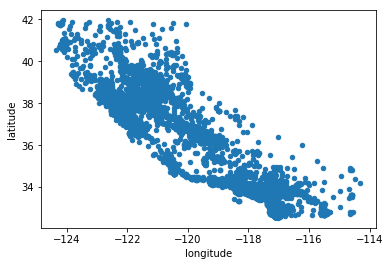

In [82]:
housing.plot(kind='scatter', x='longitude', y='latitude')

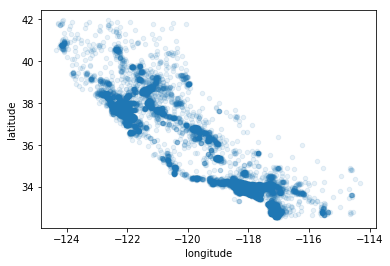

In [83]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

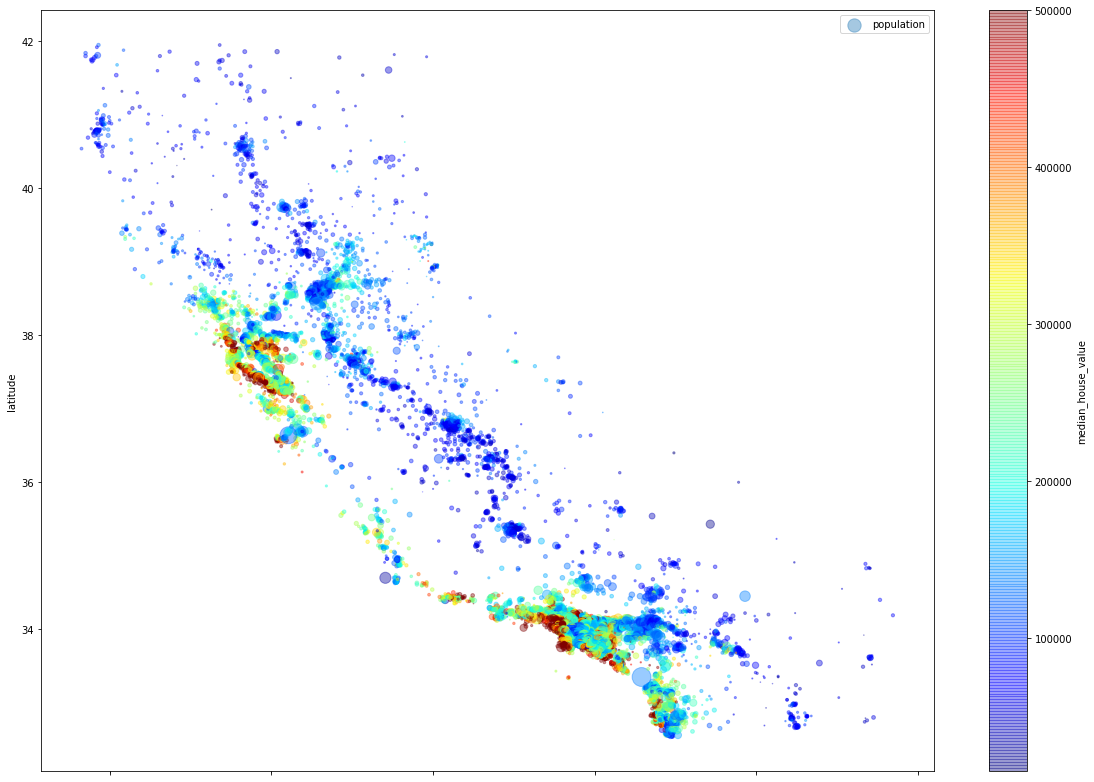

In [84]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population',
            figsize=(20,14), c='median_house_value',
             cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

Data Viz book

### Study Correlations

In [85]:
corr_matrix = housing.corr()

In [86]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686483
total_rooms           0.134094
housing_median_age    0.110399
index                 0.069719
households            0.064649
total_bedrooms        0.047810
population           -0.025702
longitude            -0.045299
latitude             -0.142788
Name: median_house_value, dtype: float64

Non-linear correlations can be missed!

In [87]:
import pandas as pd
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f95ed30>,
      dtype=object)

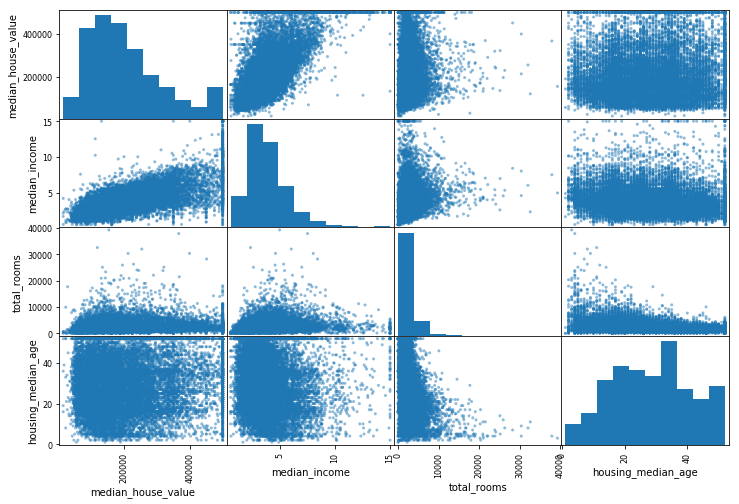

In [88]:
attributes = ['median_house_value', 'median_income', 'total_rooms',
             'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

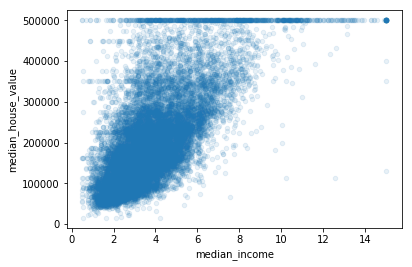

In [89]:
housing.plot(kind='scatter', x='median_income', y='median_house_value',
            alpha=0.1)

### Experimenting w/ Attribute Combinations

In [90]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['populations_per_household'] = housing['population']/housing['households']

In [91]:
corr_matrix = housing.corr()

In [92]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.686483
rooms_per_household          0.155624
total_rooms                  0.134094
housing_median_age           0.110399
index                        0.069719
households                   0.064649
total_bedrooms               0.047810
population                  -0.025702
populations_per_household   -0.032873
longitude                   -0.045299
latitude                    -0.142788
bedrooms_per_room           -0.257573
Name: median_house_value, dtype: float64

## Prepare for ML

### Deal w/ missing data

In [93]:
# Reset to a clean dataset
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [94]:
#housing.dropna(subset=["total_bedrooms"])    # drop rows
#housing.drop("total_bedrooms", axis=1)       # drop column
#median = housing["total_bedrooms"].median()  # fillna w median
#housing["total_bedrooms"].fillna(median, inplace=True)

In [95]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

In [96]:
#can only use Imputer on numerical df, so drop the categorical col
housing_num = housing.drop('ocean_proximity', axis=1)

In [97]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

Saving the imputed values is important for later use in the test set

In [98]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [99]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [100]:
X = imputer.transform(housing_num)

In [101]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling text and categorical

In [146]:
house_cat = housing[['ocean_proximity']]

In [147]:
house_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [148]:
from future_encoders import OneHotEncoder #to be included in sklearn 0.20

In [149]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(house_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [151]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformations

In [107]:
# This will allow you to automate the creation of new attributes
# Also, the bedrooms_per_room is a hyperparameter so it can be tuned
# This allows you to gate and try any data prep steps

In [108]:
from sklearn.base import BaseEstimator, TransformerMixin

In [109]:
#Number of the column where data is housed
rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

In [110]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/ X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [111]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

In [112]:
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling & Pipeline Creation

In [113]:
#MinMax scaling (aka normalization), 0-1, required by some NN
#Standardization (subtract mean, divide by var) less sensitive to outliers

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [115]:
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [116]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [117]:
from future_encoders import ColumnTransformer #to be included in sklearn.compose 0.20

In [118]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

In [119]:
housing_prepared = full_pipeline.fit_transform(housing)

In [120]:
housing_prepared.shape

(16512, 17)

## Select & Train a Model

### Train and Eval on Training Set

In [121]:
from sklearn.linear_model import LinearRegression

In [122]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [153]:
#Try the model out
some_data = housing.iloc[:5]
some_lables = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_lables))

Predictions: [203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [124]:
#Quantify fit
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.64295459937

In [125]:
#Try decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [126]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

![Model Fitting](https://cdn-images-1.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png)

### Cross Validation

![Cross Validation](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

In [127]:
from sklearn.model_selection import cross_val_score

In [128]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [129]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('STD:', scores.std())

In [130]:
display_scores(tree_rmse_scores)

Scores: [69328.68728327 68339.79770448 71032.9325559  69886.2626279
 72174.93824398 74569.29424457 70964.13490236 71485.32533506
 76572.22245073 70089.86828712]
Mean: 71444.34636353684
STD: 2353.1296622216073


In [131]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66877.52325028 66608.120256   70575.91118868 74179.94799352
 67683.32205678 71103.16843468 64782.65896552 67711.29940352
 71080.40484136 67687.6384546 ]
Mean: 68828.99948449328
STD: 2662.7615706103443


In [132]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

//anaconda/envs/notebook3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Scores: [51240.90384891 50170.3441948  53069.50013135 53630.52510906
 52491.50987819 56168.20648774 51756.7630402  50109.51842963
 55853.70403759 53114.46282117]
Mean: 52760.54379786299
STD: 1982.011997190637


In [133]:
#Save the model
from sklearn.externals import joblib

joblib.dump(forest_reg, 'forest_reg.pkl')
#forest_reg_loaded = joblib.load('forest_reg.pkl')

['forest_reg.pkl']

## Fine Tune Model

### Grid Search

In [134]:
from sklearn.model_selection import GridSearchCV

In [135]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10], 'max_features':[2,3,4]}
]

In [136]:
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'max_features': [2, 3, 4], 'bootstrap': [False], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [137]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [138]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Feature Importance

In [139]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [156]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"]
#cat_encoder - full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.27858035198598796, 'median_income'),
 (0.16170398342553888, 'income_cat'),
 (0.12428124299806821, 'INLAND'),
 (0.11253252640999901, 'pop_per_hhold'),
 (0.06249802283855097, 'longitude'),
 (0.05612618427771059, 'latitude'),
 (0.04766593461677034, 'bedrooms_per_room'),
 (0.04529209866957141, 'housing_median_age'),
 (0.03506671512450131, 'rooms_per_hhold'),
 (0.016119525769114067, 'total_rooms'),
 (0.01610079199621981, 'population'),
 (0.016061556819909114, 'total_bedrooms'),
 (0.015125493950806541, 'households'),
 (0.006786696980445052, '<1H OCEAN'),
 (0.003778259664362749, 'NEAR OCEAN'),
 (0.0022214487499870876, 'NEAR BAY'),
 (5.9165722456784304e-05, 'ISLAND')]

## Evaluate on the Test Set

In [157]:
final_model = grid_search.best_estimator_

In [158]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48698.396070060866